In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('max_colwidth', 5000)
import pandas_profiling
from IPython.display import display
from feature_engine.categorical_encoders import OneHotCategoricalEncoder

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [5]:
from sklearn import linear_model
import scipy.stats as stat

In [6]:
class LogisticRegression_with_p_values:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 

    self.z_scores
    self.p_values
    self.sigma_estimates

    as well as the negative hessian of the log Likelihood (Fisher information)

    self.F_ij
    """
    def __init__(self, *args, **kwargs):
        self.model = linear_model.LogisticRegression(*args, **kwargs)
    def fit(self, X, y):
        self.model.fit(X,y)
        # Get p-values for the fitted model
        denom = (2.0 * (1 + np.cosh(self.model.decision_function(X)))) #desc_func predicts confidence score
        denom = np.tile(denom,(X.shape[1], 1)).T
        F_ij = np.dot((X / denom).T,X) # Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) # Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] # two tailed test for p-values
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

## Read In CSV Files
Remember that I now have 4 files, the train test split with and without targets

In [7]:
loan_data_inputs_train = pd.read_csv('/Users/fayadabbasi/Desktop/Python_Scripts/Galvanize/DSI/CreditRisk/loan_data_inputs_train.csv', index_col=0)

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
loan_data_targets_train = pd.read_csv('/Users/fayadabbasi/Desktop/Python_Scripts/Galvanize/DSI/CreditRisk/loan_data_target_train.csv',index_col=0, header=None)

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
loan_data_inputs_test = pd.read_csv('/Users/fayadabbasi/Desktop/Python_Scripts/Galvanize/DSI/CreditRisk/loan_data_inputs_test.csv', index_col=0)
loan_data_targets_test = pd.read_csv('/Users/fayadabbasi/Desktop/Python_Scripts/Galvanize/DSI/CreditRisk/loan_data_target_test.csv',index_col=0, header=None)

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (121,122,123,126,127,128,131) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
loan_data_inputs_train.head(1)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,emp_length_int,term_int,earliest_cr_line_date,mths_since_earliest_cr_line,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_s

In [11]:
#loan_data_inputs_train = loan_data_inputs_train.drop(['int_rate_factor_test'], axis=1)
# this should be a one time thing since it was a mistake first go around

In [10]:
loan_data_inputs_test.head(1)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,emp_length_int,term_int,earliest_cr_line_date,mths_since_earliest_cr_line,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_s

In [12]:
print("inputs train shape: {} \ntargets train shape: {}".format(loan_data_inputs_train.shape, loan_data_targets_train.shape))

inputs train shape: (1788564, 302) 
targets train shape: (1788564, 1)


In [13]:
print("inputs test shape: {} \ntargets test shape: {}".format(loan_data_inputs_test.shape, loan_data_targets_test.shape))

inputs test shape: (596188, 302) 
targets test shape: (596188, 1)


## Create working file
This will include only those modified columns from my preprocessing
<br/>
as well as my one_hot_encoding

In [14]:
list_of_woe = ['grade:A','grade:B','grade:C','grade:D','grade:E','grade:F','grade:G','sub_grade:A1','sub_grade:A2','sub_grade:A3','sub_grade:A4','sub_grade:A5','sub_grade:B1','sub_grade:B2','sub_grade:B3','sub_grade:B4','sub_grade:B5','sub_grade:C1','sub_grade:C2','sub_grade:C3','sub_grade:C4','sub_grade:C5','sub_grade:D1','sub_grade:D2','sub_grade:D3','sub_grade:D4','sub_grade:D5','sub_grade:E1','sub_grade:E2','sub_grade:E3','sub_grade:E4','sub_grade:E5','sub_grade:F1','sub_grade:F2','sub_grade:F3','sub_grade:F4','sub_grade:F5','sub_grade:G1','sub_grade:G2','sub_grade:G3','sub_grade:G4','sub_grade:G5','home_ownership:ANY','home_ownership:MORTGAGE','home_ownership:NONE','home_ownership:OTHER','home_ownership:OWN','home_ownership:RENT','verification_status:Not Verified','verification_status:Source Verified','verification_status:Verified','loan_status:Charged Off','loan_status:Current','loan_status:Default','loan_status:Does not meet the credit policy. Status:Charged Off','loan_status:Does not meet the credit policy. Status:Fully Paid','loan_status:Fully Paid','loan_status:In Grace Period','loan_status:Late (16-30 days)','loan_status:Late (31-120 days)','purpose:car','purpose:credit_card','purpose:debt_consolidation','purpose:educational','purpose:home_improvement','purpose:house','purpose:major_purchase','purpose:medical','purpose:moving','purpose:other','purpose:renewable_energy','purpose:small_business','purpose:vacation','purpose:wedding','addr_state:AK','addr_state:AL','addr_state:AR','addr_state:AZ','addr_state:CA','addr_state:CO','addr_state:CT','addr_state:DC','addr_state:DE','addr_state:FL','addr_state:GA','addr_state:HI','addr_state:IA','addr_state:ID','addr_state:IL','addr_state:IN','addr_state:KS','addr_state:KY','addr_state:LA','addr_state:MA','addr_state:MD','addr_state:ME','addr_state:MI','addr_state:MN','addr_state:MO','addr_state:MS','addr_state:MT','addr_state:NC','addr_state:ND','addr_state:NE','addr_state:NH','addr_state:NJ','addr_state:NM','addr_state:NV','addr_state:NY','addr_state:OH','addr_state:OK','addr_state:OR','addr_state:PA','addr_state:RI','addr_state:SC','addr_state:SD','addr_state:TN','addr_state:TX','addr_state:UT','addr_state:VA','addr_state:VT','addr_state:WA','addr_state:WI','addr_state:WV','addr_state:WY','initial_list_status:f','initial_list_status:w','home_ownership:NONE_RENT_OWN_MORTGAGE','addr_state:OK_AR_LA_MS','addr_state:NV_NY','addr_state:HI_FL_NM','addr_state:MD_MO_AK_PA_NC_NJ_IN','addr_state:KY_CA','addr_state:SD_NE_TN_MI_DE_VA','addr_state:MN_AZ_TX_OH','addr_state:UT_GA_WI','addr_state:IL_CT_RI_MT','addr_state:WY_KS_WA','addr_state:ND_CO','addr_state:SC_OR_DC','purpose:MOV_REN','purpose:WED_DEBTCON_MEDICAL','purpose:OTH_HOUSE','purpose:MAJPUR_VAC_HI','purpose:CC_CAR','term:36','term:60','emp_length:0','emp_length:1','emp_length:2-6','emp_length:7','emp_length:8','emp_length:9','emp_length:10']

In [15]:
exp_woe = ['grade:A','grade:B','grade:C','grade:D','grade:E','grade:F','emp_length:0','emp_length:1','emp_length:2-6','emp_length:7','emp_length:8','emp_length:9']

In [16]:
ref_categories = ['grade:G','sub_grade:G5','home_ownership:RENT','verification_status:Verified','loan_status:Late (31-120 days)','purpose:wedding','addr_state:WY','initial_list_status:w','emp_length:10']

In [17]:
inputs_train_w_ref_cat = loan_data_inputs_train.loc[:,list_of_woe]

In [18]:
inputs_train_w_ref_cat_exp = loan_data_inputs_train.loc[:,exp_woe]

In [19]:
inputs_train_w_ref_cat.head(2)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:ND,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:NONE_RENT_OWN_MORTGAGE,addr_state:OK_AR_LA_MS,addr_state:NV_NY,addr_state:HI_FL_NM,addr_state:MD_MO_AK_PA_NC_NJ_IN,addr_state:KY_CA,addr_state:SD_NE_TN_MI_DE_VA,addr_state:MN_AZ_TX_OH,addr_state:UT_GA_WI,addr_state:IL_CT_RI_MT,addr_state:WY_KS_WA,addr_state:ND_CO,addr_state:SC_OR_DC,purpose:MOV_REN,purpose:WED_DEBTCON_MEDICAL,purpose:OTH_HOUSE,purpose:MAJPUR_VAC_HI,purpose:CC_CAR,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-6,emp_length:7,emp_length:8,emp_length:9,emp_length:10
2320939,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
753254,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0


In [20]:
inputs_train_w_ref_cat_exp.shape

(1788564, 12)

In [21]:
inputs_train_w_ref_cat_exp.head(5)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,emp_length:0,emp_length:1,emp_length:2-6,emp_length:7,emp_length:8,emp_length:9
2320939,1,0,0,0,0,0,0,1,0,0,0,0
753254,0,1,0,0,0,0,0,0,1,0,0,0
708945,0,0,0,0,1,0,0,0,0,0,0,0
114462,0,0,1,0,0,0,0,0,1,0,0,0
1622908,0,1,0,0,0,0,1,0,0,0,0,0


In [22]:
loan_data_inputs_train.shape

(1788564, 302)

In [23]:
inputs_train = inputs_train_w_ref_cat.drop(ref_categories, axis=1)

#### I think this is wrong but will go with it for now
These have some redundancies in them but can adjust that

In [24]:
reg = LogisticRegression()

In [25]:
reg.fit(inputs_train, loan_data_targets_train)

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
reg_exp = LogisticRegression_with_p_values()

In [27]:
reg_exp.fit(inputs_train_w_ref_cat_exp, loan_data_targets_train)

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
loan_data_targets_train.head(5)

,1
0,
2320939,1
753254,1
708945,0
114462,1
1622908,1


In [29]:
feature_name_exp = inputs_train_w_ref_cat_exp.columns.values
summary_table_exp = pd.DataFrame(columns=['Feature name'], data=feature_name_exp)
summary_table_exp['Coefficients'] = np.transpose(reg_exp.coef_)
summary_table_exp.index = summary_table_exp.index + 1
summary_table_exp.loc[0] = ['Intercept', reg_exp.intercept_[0]]
summary_table_exp = summary_table_exp.sort_index()
summary_table_exp

,Feature name,Coefficients
0,Intercept,0.327859
1,grade:A,3.017331
2,grade:B,2.049380
3,grade:C,1.469478
4,grade:D,1.068633
5,grade:E,0.563636
6,grade:F,0.185776
7,emp_length:0,-0.170087
8,emp_length:1,-0.099816
9,emp_length:2-6,-0.070104


In [30]:
p_values_exp = reg_exp.p_values

In [31]:
p_values_exp = np.append(np.nan, np.array(p_values_exp))

In [32]:
summary_table_exp['p_values'] = p_values_exp
summary_table_exp

,Feature name,Coefficients,p_values
0,Intercept,0.327859,NaN
1,grade:A,3.017331,0.000000e+00
2,grade:B,2.049380,0.000000e+00
3,grade:C,1.469478,0.000000e+00
4,grade:D,1.068633,0.000000e+00
5,grade:E,0.563636,0.000000e+00
6,grade:F,0.185776,6.611053e-52
7,emp_length:0,-0.170087,2.294297e-133
8,emp_length:1,-0.099816,2.767029e-25
9,emp_length:2-6,-0.070104,6.839462e-36


In [33]:
feature_name = inputs_train.columns.values

In [34]:
summary_table = pd.DataFrame(columns=['Feature name'], data=feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-2.041243
1,grade:A,0.162442
2,grade:B,-0.117887
3,grade:C,-0.308311
4,grade:D,-0.430876
5,grade:E,-0.486215
6,grade:F,-0.384418
7,sub_grade:A1,0.209093
8,sub_grade:A2,0.077824
9,sub_grade:A3,0.007664


In [35]:
reg = LogisticRegression_with_p_values()

In [36]:
reg.fit(inputs_train,loan_data_targets_train)

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


In [37]:
summary_table = pd.DataFrame(columns=['Feature name'], data=feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-2.041243
1,grade:A,0.162442
2,grade:B,-0.117887
3,grade:C,-0.308311
4,grade:D,-0.430876
5,grade:E,-0.486215
6,grade:F,-0.384418
7,sub_grade:A1,0.209093
8,sub_grade:A2,0.077824
9,sub_grade:A3,0.007664


In [38]:
p_values = reg.p_values

In [39]:
p_values = np.append(np.nan, np.array(p_values))

In [40]:
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-2.041243,NaN
1,grade:A,0.162442,NaN
2,grade:B,-0.117887,1.000000e+00
3,grade:C,-0.308311,NaN
4,grade:D,-0.430876,NaN
5,grade:E,-0.486215,9.999999e-01
6,grade:F,-0.384418,NaN
7,sub_grade:A1,0.209093,NaN
8,sub_grade:A2,0.077824,NaN
9,sub_grade:A3,0.007664,NaN


### Go back and drop the p_values that are not relevant

In [41]:
reg2 = LogisticRegression_with_p_values()

In [42]:
reg2.fit(inputs_train, loan_data_targets_train)

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


In [43]:
p_values = reg2.p_values
p_values = np.append(np.nan, np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-2.041243,NaN
1,grade:A,0.162442,NaN
2,grade:B,-0.117887,1.000000e+00
3,grade:C,-0.308311,NaN
4,grade:D,-0.430876,NaN
5,grade:E,-0.486215,9.999999e-01
6,grade:F,-0.384418,NaN
7,sub_grade:A1,0.209093,NaN
8,sub_grade:A2,0.077824,NaN
9,sub_grade:A3,0.007664,NaN


### Once set with the right columns, apply to the test dataframe

In [44]:
inputs_test_w_ref_cat = loan_data_inputs_test.loc[:,list_of_woe]

In [45]:
inputs_test_w_ref_cat_exp = loan_data_inputs_test.loc[:,exp_woe]

In [46]:
inputs_test = inputs_test_w_ref_cat.drop(ref_categories, axis=1)

In [47]:
yhat_test = reg2.model.predict(inputs_test)
# prob <= 50% --> Bad, 0
# prob > 50% --> Good, 1

In [48]:
yhat_test_exp = reg_exp.model.predict(inputs_test_w_ref_cat_exp)

In [49]:
yhat_test_proba = reg2.model.predict_proba(inputs_test)
# should give me probability of good versus bad as an array

In [50]:
yhat_test_proba_exp = reg_exp.model.predict_proba(inputs_test_w_ref_cat_exp)

In [51]:
yhat_test_proba

array([[1.57075619e-05, 9.99984292e-01],
       [3.34997379e-05, 9.99966500e-01],
       [2.36861156e-05, 9.99976314e-01],
       ...,
       [2.41130065e-05, 9.99975887e-01],
       [3.70089483e-05, 9.99962991e-01],
       [9.99966507e-01, 3.34931442e-05]])

In [52]:
yhat_test_proba = yhat_test_proba[: ][: ,1]

In [53]:
yhat_test_proba_exp = yhat_test_proba_exp[: ][: ,1]

In [54]:
yhat_test_proba

array([9.99984292e-01, 9.99966500e-01, 9.99976314e-01, ...,
       9.99975887e-01, 9.99962991e-01, 3.34931442e-05])

In [55]:
yhat_test_proba_exp

array([0.91507509, 0.70919848, 0.90946621, ..., 0.8016266 , 0.8490582 ,
       0.8490582 ])

In [56]:
loan_data_targets_test_temp = loan_data_targets_test

In [57]:
loan_data_targets_test_temp.shape

(596188, 1)

In [58]:
yhat_test_proba_exp.shape

(596188,)

In [59]:
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)

In [60]:
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(yhat_test_proba)], axis=1)

In [61]:
df_actual_predicted_probs_exp = pd.concat([loan_data_targets_test_temp, pd.DataFrame(yhat_test_proba_exp)], axis=1)

In [62]:
df_actual_predicted_probs.shape

(596188, 2)

In [63]:
df_actual_predicted_probs_exp.shape

(596188, 2)

In [64]:
df_actual_predicted_probs.columns = ['loan_data_targets_test','yhat_test_proba']

In [65]:
df_actual_predicted_probs_exp.columns = ['loan_data_targets_test','yhat_test_proba_exp']

In [66]:
df_actual_predicted_probs.index = loan_data_inputs_test.index

In [67]:
df_actual_predicted_probs_exp.index = loan_data_inputs_test.index

In [68]:
df_actual_predicted_probs.head()

,loan_data_targets_test,yhat_test_proba
560978,1,0.999984
747942,1,0.999967
1447333,1,0.999976
2097488,1,0.999967
1923437,1,0.999964


In [69]:
df_actual_predicted_probs_exp.head(20)

,loan_data_targets_test,yhat_test_proba_exp
560978,1,0.915075
747942,1,0.709198
1447333,1,0.909466
2097488,1,0.835793
1923437,1,0.672917
298598,0,0.709198
365012,1,0.857824
828712,1,0.909466
2014113,1,0.965947
1870988,1,0.790243


## Accuracy and area under the curve

In [70]:
tr = 0.5
df_actual_predicted_probs['yhat_test'] = np.where(df_actual_predicted_probs['yhat_test_proba'] > tr, 1, 0)

In [71]:
tr = 0.5
df_actual_predicted_probs_exp['yhat_test'] = np.where(df_actual_predicted_probs_exp['yhat_test_proba_exp'] > tr, 1, 0)

In [72]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,78854,0
1,0,517334


In [73]:
pd.crosstab(df_actual_predicted_probs_exp['loan_data_targets_test'], df_actual_predicted_probs_exp['yhat_test'], rownames=['Actual'], colnames=['Predicted'])

Predicted,1
Actual,
0,78854
1,517334


In [74]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test'], rownames=['Actual'], colnames=['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.132264,0.000000
1,0.000000,0.867736


In [75]:
pd.crosstab(df_actual_predicted_probs_exp['loan_data_targets_test'], df_actual_predicted_probs_exp['yhat_test'], rownames=['Actual'], colnames=['Predicted']) / df_actual_predicted_probs_exp.shape[0]

Predicted,1
Actual,
0,0.132264
1,0.867736


In [76]:
from sklearn.metrics import roc_curve, roc_auc_score

In [77]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test_proba'])

(array([0.        , 0.        , 0.        , ..., 0.99991123, 0.99996196,
        1.        ]),
 array([1.93298720e-06, 6.37885776e-05, 6.76545520e-05, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([9.99998285e-01, 9.99997113e-01, 9.99997098e-01, ...,
        2.00900510e-05, 1.99100727e-05, 1.89387473e-05]))

In [78]:
roc_curve(df_actual_predicted_probs_exp['loan_data_targets_test'], df_actual_predicted_probs_exp['yhat_test_proba_exp'])

(array([0.        , 0.01765288, 0.03642174, 0.03869176, 0.04244553,
        0.04437315, 0.04657975, 0.05738453, 0.12007   , 0.18748573,
        0.19565273, 0.20941233, 0.2163492 , 0.22442742, 0.25837624,
        0.35591092, 0.46418698, 0.47789586, 0.49956882, 0.51090623,
        0.52451366, 0.57824587, 0.64781749, 0.72545464, 0.73521952,
        0.75097015, 0.75893423, 0.76858498, 0.80764451, 0.84766784,
        0.89091232, 0.89649225, 0.90503969, 0.90996018, 0.91597129,
        0.93518401, 0.95132777, 0.96829584, 0.97050245, 0.97379968,
        0.97585411, 0.97866944, 0.98546681, 0.99033657, 0.99494002,
        0.99572628, 0.9966774 , 0.99715931, 0.99797093, 1.        ]),
 array([0.        , 0.07665454, 0.15305973, 0.16208098, 0.1766383 ,
        0.18425814, 0.19325426, 0.22936246, 0.3313662 , 0.43470756,
        0.44713087, 0.46734411, 0.47754449, 0.48969331, 0.53568681,
        0.6262202 , 0.71841209, 0.72923489, 0.74747069, 0.75672003,
        0.76774192, 0.80907306, 0.85209362, 0.

In [79]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test_proba'])

In [80]:
fpr_exp, tpr_exp, thresholds_exp = roc_curve(df_actual_predicted_probs_exp['loan_data_targets_test'], df_actual_predicted_probs_exp['yhat_test_proba_exp'])

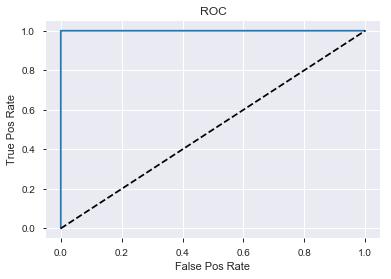

In [81]:
plt.plot(fpr,tpr)
plt.plot(fpr,fpr, linestyle='--', color='k')
plt.title('ROC')
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate');

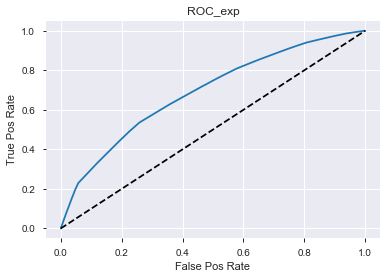

In [82]:
plt.plot(fpr_exp,tpr_exp)
plt.plot(fpr_exp,fpr_exp, linestyle='--', color='k')
plt.title('ROC_exp')
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate');

In [83]:
auroc = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test_proba'])

In [84]:
auroc

1.0

In [85]:
auroc_exp = roc_auc_score(df_actual_predicted_probs_exp['loan_data_targets_test'], df_actual_predicted_probs_exp['yhat_test_proba_exp'])
auroc_exp

0.6898418963149551

In [105]:
reg_exp_train = LogisticRegression().fit(inputs_train_w_ref_cat_exp, y_glb)

In [106]:
print("Accuracy on training set: {:.3f}".format(reg_exp_train.score(inputs_train_w_ref_cat_exp, y_glb)))

Accuracy on training set: 0.868


### Run a Gradient Boosted Classifier on the exp data

In [86]:
from sklearn.ensemble import GradientBoostingClassifier

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [87]:
loan_data_targets_train.shape

(1788564, 1)

In [96]:
y_glb = loan_data_targets_train.iloc[:,0]

In [97]:
y_glb.shape

(1788564,)

In [107]:
gbl = GradientBoostingClassifier(loss='deviance', learning_rate=0.01, n_estimators=500, subsample=0.5, min_samples_leaf=12, max_depth=2, random_state=42).fit(inputs_train_w_ref_cat_exp, y_glb)

In [108]:
print("Accuracy on training set: {:.3f}".format(gbl.score(inputs_train_w_ref_cat_exp, y_glb)))

Accuracy on training set: 0.868


In [101]:
gbl.score(inputs_train_w_ref_cat_exp, y_glb)

0.8676686995824583

In [ ]:
for name, imp in sorted(zip(list(X_train.keys()), gbl.feature_importances_), key=lambda x: x[1], reverse=True):
    print("Feature {} has an importance score of {}".format(name, imp))

### Gini

In [86]:
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('yhat_test_proba')
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
df_actual_predicted_probs['Cum_N_Pop'] = df_actual_predicted_probs.index+1
df_actual_predicted_probs['Cum_N_Good'] = df_actual_predicted_probs['loan_data_targets_test'].cumsum()
df_actual_predicted_probs['Cum_N_Bad'] = df_actual_predicted_probs['Cum_N_Pop'] - df_actual_predicted_probs['loan_data_targets_test'].cumsum()
df_actual_predicted_probs['Cum_Perc_Pop'] = df_actual_predicted_probs['Cum_N_Pop'] / (df_actual_predicted_probs.shape[0])
df_actual_predicted_probs['Cum_Perc_Good'] = df_actual_predicted_probs['Cum_N_Good'] / df_actual_predicted_probs['loan_data_targets_test'].sum()
df_actual_predicted_probs['Cum_Perc_Bad'] = df_actual_predicted_probs['Cum_N_Bad'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['loan_data_targets_test'].sum())

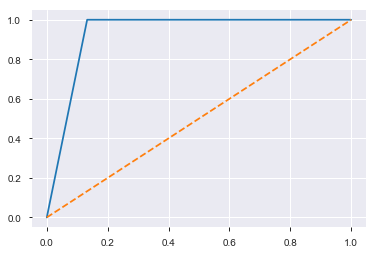

In [87]:
plt.plot(df_actual_predicted_probs['Cum_Perc_Pop'], df_actual_predicted_probs['Cum_Perc_Bad'])
plt.plot(df_actual_predicted_probs['Cum_Perc_Pop'], df_actual_predicted_probs['Cum_Perc_Pop'], linestyle='--');

## Convert PD Model to Score

In [89]:
df_ref_cat = pd.DataFrame(ref_categories, columns=['Feature name'])
df_ref_cat['Coefficients'] = 0
df_ref_cat['p-value'] = np.nan

In [90]:
df_scorecard = pd.concat([summary_table, df_ref_cat])
df_scorecard.reset_index()
df_scorecard['Original_Feature_Name'] = df_scorecard['Feature name'].str.split(':').str[0]

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [91]:
df_scorecard

,Coefficients,Feature name,p-value,p_values,Original_Feature_Name
0,-2.041243,Intercept,NaN,NaN,Intercept
1,0.162442,grade:A,NaN,NaN,grade
2,-0.117887,grade:B,NaN,1.000000e+00,grade
3,-0.308311,grade:C,NaN,NaN,grade
4,-0.430876,grade:D,NaN,NaN,grade
5,-0.486215,grade:E,NaN,9.999999e-01,grade
6,-0.384418,grade:F,NaN,NaN,grade
7,0.209093,sub_grade:A1,NaN,NaN,sub_grade
8,0.077824,sub_grade:A2,NaN,NaN,sub_grade
9,0.007664,sub_grade:A3,NaN,NaN,sub_grade


In [92]:
min_score = 300
max_score = 850

In [93]:
min_sum_coef = df_scorecard.groupby('Original_Feature_Name')['Coefficients'].min().sum()
min_sum_coef

-10.60730707112345

In [94]:
max_sum_coef = df_scorecard.groupby('Original_Feature_Name')['Coefficients'].max().sum()
max_sum_coef

14.164364180330407

In [95]:
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard

,Coefficients,Feature name,p-value,p_values,Original_Feature_Name,Score - Calculation
0,-2.041243,Intercept,NaN,NaN,Intercept,-45.321281
1,0.162442,grade:A,NaN,NaN,grade,3.606666
2,-0.117887,grade:B,NaN,1.000000e+00,grade,-2.617412
3,-0.308311,grade:C,NaN,NaN,grade,-6.845371
4,-0.430876,grade:D,NaN,NaN,grade,-9.566637
5,-0.486215,grade:E,NaN,9.999999e-01,grade,-10.795321
6,-0.384418,grade:F,NaN,NaN,grade,-8.535154
7,0.209093,sub_grade:A1,NaN,NaN,sub_grade,4.642436
8,0.077824,sub_grade:A2,NaN,NaN,sub_grade,1.727920
9,0.007664,sub_grade:A3,NaN,NaN,sub_grade,0.170156


In [96]:
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
df_scorecard

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Coefficients,Feature name,p-value,p_values,Original_Feature_Name,Score - Calculation
0,-2.041243,Intercept,NaN,NaN,Intercept,490.190439
1,0.162442,grade:A,NaN,NaN,grade,3.606666
2,-0.117887,grade:B,NaN,1.000000e+00,grade,-2.617412
3,-0.308311,grade:C,NaN,NaN,grade,-6.845371
4,-0.430876,grade:D,NaN,NaN,grade,-9.566637
5,-0.486215,grade:E,NaN,9.999999e-01,grade,-10.795321
6,-0.384418,grade:F,NaN,NaN,grade,-8.535154
7,0.209093,sub_grade:A1,NaN,NaN,sub_grade,4.642436
8,0.077824,sub_grade:A2,NaN,NaN,sub_grade,1.727920
9,0.007664,sub_grade:A3,NaN,NaN,sub_grade,0.170156


In [97]:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,Coefficients,Feature name,p-value,p_values,Original_Feature_Name,Score - Calculation,Score - Preliminary
0,-2.041243,Intercept,NaN,NaN,Intercept,490.190439,490.0
1,0.162442,grade:A,NaN,NaN,grade,3.606666,4.0
2,-0.117887,grade:B,NaN,1.000000e+00,grade,-2.617412,-3.0
3,-0.308311,grade:C,NaN,NaN,grade,-6.845371,-7.0
4,-0.430876,grade:D,NaN,NaN,grade,-9.566637,-10.0
5,-0.486215,grade:E,NaN,9.999999e-01,grade,-10.795321,-11.0
6,-0.384418,grade:F,NaN,NaN,grade,-8.535154,-9.0
7,0.209093,sub_grade:A1,NaN,NaN,sub_grade,4.642436,5.0
8,0.077824,sub_grade:A2,NaN,NaN,sub_grade,1.727920,2.0
9,0.007664,sub_grade:A3,NaN,NaN,sub_grade,0.170156,0.0


In [98]:
min_sum_score_pre1 = df_scorecard.groupby('Original_Feature_Name')['Score - Preliminary'].min().sum()
min_sum_score_pre1

300.0

In [99]:
max_sum_score_pre1 = df_scorecard.groupby('Original_Feature_Name')['Score - Preliminary'].max().sum()
max_sum_score_pre1 - 536
# I need to drop the redundant columns - like grade:G 
# also have some rounding that is resulting in sum coming out lower than 850

847.0

In [100]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard['Score - Final'][146] = 0

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [101]:
df_scorecard

,Coefficients,Feature name,p-value,p_values,Original_Feature_Name,Score - Calculation,Score - Preliminary,Score - Final
0,-2.041243,Intercept,NaN,NaN,Intercept,490.190439,490.0,490.0
1,0.162442,grade:A,NaN,NaN,grade,3.606666,4.0,4.0
2,-0.117887,grade:B,NaN,1.000000e+00,grade,-2.617412,-3.0,-3.0
3,-0.308311,grade:C,NaN,NaN,grade,-6.845371,-7.0,-7.0
4,-0.430876,grade:D,NaN,NaN,grade,-9.566637,-10.0,-10.0
5,-0.486215,grade:E,NaN,9.999999e-01,grade,-10.795321,-11.0,-11.0
6,-0.384418,grade:F,NaN,NaN,grade,-8.535154,-9.0,-9.0
7,0.209093,sub_grade:A1,NaN,NaN,sub_grade,4.642436,5.0,5.0
8,0.077824,sub_grade:A2,NaN,NaN,sub_grade,1.727920,2.0,2.0
9,0.007664,sub_grade:A3,NaN,NaN,sub_grade,0.170156,0.0,0.0


### Calculating Credit Score

In [102]:
inputs_test_w_ref_cat.head(1)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:ND,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:NONE_RENT_OWN_MORTGAGE,addr_state:OK_AR_LA_MS,addr_state:NV_NY,addr_state:HI_FL_NM,addr_state:MD_MO_AK_PA_NC_NJ_IN,addr_state:KY_CA,addr_state:SD_NE_TN_MI_DE_VA,addr_state:MN_AZ_TX_OH,addr_state:UT_GA_WI,addr_state:IL_CT_RI_MT,addr_state:WY_KS_WA,addr_state:ND_CO,addr_state:SC_OR_DC,purpose:MOV_REN,purpose:WED_DEBTCON_MEDICAL,purpose:OTH_HOUSE,purpose:MAJPUR_VAC_HI,purpose:CC_CAR,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-6,emp_length:7,emp_length:8,emp_length:9,emp_length:10
560978,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1


In [103]:
inputs_test_with_ref_cat_w_intercept = inputs_test_w_ref_cat

In [104]:
inputs_test_with_ref_cat_w_intercept.insert(0,'Intercept',1)

In [105]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]

In [106]:
inputs_test_with_ref_cat_w_intercept.head(1)

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,verification_status:Not Verified,verification_status:Source Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:ND,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,initial_list_status:f,home_ownership:NONE_RENT_OWN_MORTGAGE,addr_state:OK_AR_LA_MS,addr_state:NV_NY,addr_state:HI_FL_NM,addr_state:MD_MO_AK_PA_NC_NJ_IN,addr_state:KY_CA,addr_state:SD_NE_TN_MI_DE_VA,addr_state:MN_AZ_TX_OH,addr_state:UT_GA_WI,addr_state:IL_CT_RI_MT,addr_state:WY_KS_WA,addr_state:ND_CO,addr_state:SC_OR_DC,purpose:MOV_REN,purpose:WED_DEBTCON_MEDICAL,purpose:OTH_HOUSE,purpose:MAJPUR_VAC_HI,purpose:CC_CAR,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-6,emp_length:7,emp_length:8,emp_length:9,grade:G,sub_grade:G5,home_ownership:RENT,verification_status:Verified,loan_status:Late (31-120 days),purpose:wedding,addr_state:WY,initial_list_status:w,emp_length:10
560978,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [107]:
df_scorecard.head(1)

,Coefficients,Feature name,p-value,p_values,Original_Feature_Name,Score - Calculation,Score - Preliminary,Score - Final
0,-2.041243,Intercept,NaN,NaN,Intercept,490.190439,490.0,490.0


In [108]:
scorecard_scores = df_scorecard['Score - Final']

In [109]:
inputs_test_with_ref_cat_w_intercept.shape

(596188, 155)

In [110]:
scorecard_scores = scorecard_scores[:155]

In [111]:
scorecard_scores = scorecard_scores.values.reshape(155,1)

In [112]:
y_scores = inputs_test_with_ref_cat_w_intercept.dot(scorecard_scores)

In [114]:
y_scores.head(10)

,0
560978,781.0
747942,764.0
1447333,773.0
2097488,765.0
1923437,762.0
298598,307.0
365012,779.0
828712,777.0
2014113,779.0
1870988,762.0


## Now that I have credit score, can convert that to probability of default

In [117]:
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef

In [119]:
yhat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)
yhat_proba_from_score.head(1)

,0
560978,0.999984


### Can set arbitrary cut off for credit score

In [120]:
df_cutoff = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis=1)

In [121]:
df_cutoff.columns = ['thresholds','fpr','tpr']

In [122]:
df_cutoff.head(2)

,thresholds,fpr,tpr
0,0.999998,0.0,0.000002
1,0.999997,0.0,0.000064


In [124]:
df_cutoff['thresholds'][0] = 1 - 1 / np.power(10,16)

In [127]:
df_cutoff['Score'] = ((np.log(df_cutoff['thresholds'] / (1-df_cutoff['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()

In [128]:
df_cutoff.head(2)

,thresholds,fpr,tpr,Score
0,1.000000,0.0,0.000002,1351.0
1,0.999997,0.0,0.000064,819.0


In [129]:
df_cutoff['Score'][0] = max_score

In [130]:
df_cutoff.head(2)

,thresholds,fpr,tpr,Score
0,1.000000,0.0,0.000002,850.0
1,0.999997,0.0,0.000064,819.0


In [131]:
df_cutoff.tail(2)

,thresholds,fpr,tpr,Score
149430,0.000020,0.999962,1.0,295.0
149431,0.000019,1.000000,1.0,294.0


In [132]:
def n_approved(p):
    return np.where(df_actual_predicted_probs['yhat_test_proba'] >= p, 1,0).sum()

In [133]:
df_cutoff['N Approved'] = df_cutoff['thresholds'].apply(n_approved)
df_cutoff['N Rejected'] = df_actual_predicted_probs['yhat_test_proba'].shape[0] - df_cutoff['N Approved']
df_cutoff['Approval Rate'] = df_cutoff['N Approved'] / df_actual_predicted_probs['yhat_test_proba'].shape[0]
df_cutoff['Rejection Rate'] = 1 - df_cutoff['Approval Rate']

KeyboardInterrupt: 

In [ ]:
df_cutoff.head(3)

In [ ]:
# inputs_train_w_ref_cat.to_csv('inputs_test_w_ref_cat.csv')

In [ ]:
# df_scorecard.to_csv('df_scorecard.csv')

In [134]:
from IPython.display import display

**Population Stability Index**
$$ PSI = \sum_{j=1}^{k} \left[\left(\% actual_j - \% expected_j\right) * ln \left(\frac {\% actual_j} {\% expected_j}\right) \right]$$



# Create PSI (not necessary - relevant for changing population) then LGD then EAD and then DONE!!!